# CSC2042S 2025
# Assignment 3
# Logistic Regression
# News Classification

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import WeightedRandomSampler
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
    torch.backends.cudnn.deterministic = True

set_seed(42)

# 1. Data processing

In [4]:
def cleaner(text):
    """precautionary data text cleaning to handle white sapces and punctuation """
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)#white space 
    
    text = re.sub(r'[^\w\s]', ' ', text)#punctuation 
    
    return text.strip()

In [5]:
def loading(language='eng'):
    """MAIN  DATA LOADING METHOD"""
    base_path = f"A3-dataset/{language}"

    #FIRST WE LOAD THE LABELS
    with open(f"{base_path}/labels.txt", 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    #THEN WE LOAD OUR DATA 
    train_df = pd.read_csv(f"{base_path}/train.tsv", sep='\t', encoding='utf-8')
    dev_df = pd.read_csv(f"{base_path}/dev.tsv", sep='\t', encoding='utf-8')
    test_df = pd.read_csv(f"{base_path}/test.tsv", sep='\t', encoding='utf-8')

    #COMBINE THE TEXT AND THE HEADLINE 
    train_texts = (train_df['headline'] + " " + train_df['text']).apply(cleaner).tolist()
    dev_texts = (dev_df['headline'] + " " + dev_df['text']).apply(cleaner).tolist()
    test_texts = (test_df['headline'] + " " + test_df['text']).apply(cleaner).tolist()

    label_to_id = {label: i for i, label in enumerate(labels)}
    y_train = torch.tensor([label_to_id[cat] for cat in train_df['category']])
    y_dev = torch.tensor([label_to_id[cat] for cat in dev_df['category']])
    y_test = torch.tensor([label_to_id[cat] for cat in test_df['category']])

    return train_texts, dev_texts, test_texts, y_train, y_dev, y_test, labels

    


In [6]:
train_eng, dev_eng, test_eng, y_train_eng, y_dev_eng, y_test_eng, labels_eng = loading('eng')
train_xho, dev_xho, test_xho, y_train_xho, y_dev_xho, y_test_xho, labels_xho = loading('xho')

print(">>> Loaded the data!! <<<")

>>> Loaded the data!! <<<


In [57]:
#for isXhosa I consulted deepsek ai to get some custom stop words for experimenting to see if perfomance can be further improved later 
ISIXHOSA_STOP_WORDS = ['na', 'kwaye', 'kodwa', 'ngoku','kanjalo', 'ke', 'pha', 'apha', 'khona',
'ukuba', 'ukuze', 'ukuthi', 'nga', 'ngoku', 'kanti', 'futhi', 'nje']

class FeatureExtraction:
    """Implement three feature extraction methods with an extra parameter :language stopwords"""
    
    def __init__(self, method='bow', max_features=5000,min_df=5 , max_df=0.90, remove_stopwords=True, language='eng'):
        self.method = method
        # Foe later experimentation for task5: the following parameters >>>mid_df and max_features
        self.min_df = min_df 
        self.max_features = max_features
        self.max_df = max_df
        self.remove_stopwords = remove_stopwords
        self.language = language
        self.vectorizer = None
        
    def fit(self, texts):
        """Fit vectorizer with language-appropriate stop words"""
        if self.remove_stopwords:
            if self.language == 'eng':
                stop_words = 'english'  #Using the default stop words for english 
            elif self.language == 'xho':
                stop_words = ISIXHOSA_STOP_WORDS  #Using my custom made one for isiXhosa 
            else:
                stop_words = None
        else:
            stop_words = None
        
        if self.method == 'bow': #bag of wordd method 
            self.vectorizer = CountVectorizer(max_features=self.max_features, min_df=self.min_df, max_df=self.max_df, lowercase=False,stop_words=stop_words) 
            
        elif self.method == 'binary': # binary ,presence matters mnore than frequency
            self.vectorizer = CountVectorizer(max_features=self.max_features, min_df=self.min_df, max_df=self.max_df, binary=True, lowercase=False,stop_words=stop_words)
            
        elif self.method == 'tfidf': #the more sophisticated TFIDF
            self.vectorizer = TfidfVectorizer(max_features=self.max_features, min_df=self.min_df, max_df=self.max_df, lowercase=False,stop_words=stop_words)
        
        self.vectorizer.fit(texts)
        return self
    
    def transform(self, texts):
        """Transform texts to feature tensors"""
        features = self.vectorizer.transform(texts)
        return torch.tensor(features.toarray(), dtype=torch.float32)

In [58]:
#A little testing
extractor = FeatureExtraction(method='bow', max_features=1000, language='eng')
X_train_eng = extractor.fit(train_eng).transform(train_eng)
X_dev_eng = extractor.transform(dev_eng)

print(f"Feature matrix: {X_train_eng.shape}")
print(f"Sample feature vector: {X_train_eng[0][:10]}")  #first ten features using the default bag of words

Feature matrix: torch.Size([3309, 1000])
Sample feature vector: tensor([0., 2., 0., 0., 1., 0., 0., 0., 0., 0.])


In [59]:
# Printing the vocab sizes ,foe English I always keep the the stop words
extractor_eng = FeatureExtraction(language='eng', remove_stopwords=True)
extractor_eng.fit(train_eng)
print(f"English vocab size: {len(extractor_eng.vectorizer.vocabulary_)}")

#Testing using the custom words,for isiXhosa  
extractor_xho = FeatureExtraction(language='xho', remove_stopwords=True)
extractor_xho.fit(train_xho)

extractor_xho_2 = FeatureExtraction(language='xho', remove_stopwords=False)
extractor_xho_2.fit(train_xho)

#comparing vocabulary sizes
print(f"isiXhosa vocab size after removing stop words: {len(extractor_xho.vectorizer.vocabulary_)}")

print(f"isiXhosa vocab size with the stop words present : {len(extractor_xho_2.vectorizer.vocabulary_)}")

English vocab size: 5000
isiXhosa vocab size after removing stop words: 5000
isiXhosa vocab size with the stop words present : 5000


# 2. Multinomial logistic regression implementation  

In [60]:
class MultinomialLogisticRegression(nn.Module):
    """Multinomial Logistic Regression class"""
    
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        return self.linear(x)
    
    def compute_probabilities(self, x):
        """Returns: softmax probabilities for each class for analysis """ 
        logits = self.forward(x)
        return torch.softmax(logits, dim=1)
    
    def predict(self, x):
        probabilities = self.compute_probabilities(x)
        return torch.argmax(probabilities, dim=1) # returning thr class that has the highest probability
    def get_weights(self):
        return self.linear.weight.data, self.linear.bias.data #returning the weights learnt for later analysis 
        

# 3. Training

In [61]:
class NewsClassifierTrainer:
    """Training class"""
    def __init__(self, model, criterion, optimizer, device='cpu'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model.to(self.device)
        
        self.val_accuracies = []
        self.train_losses = []#save training history
        self.val_losses = []
        self.train_accuracies = []
       
        
    def train_epoch(self, train_loader):
        """Per epoch"""
        self.model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad() #forward passing
            output = self.model(data)
            loss = self.criterion(output, target)
            
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item() #keeping track
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                val_loss += self.criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        avg_loss = val_loss / len(val_loader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy
    
    def train(self, train_loader, val_loader, num_epochs=100, early_stopping=True, patience=5, min_epochs=10, printer=True):
        
        """Main training loop allwing for experimenting with different stopping conditoins i.e : early stopping and maximum number of training epochs
            min_epochs: Minimum number of epochs to train even for early stopping to make sure that the models learn something"""
        
        best_val_accuracy = 0
        patience_counter = 0
        best_model_state = None
        
        if printer:
            print("Model is training...")
            stopping_criteria = "Early Stopping" if early_stopping else f"Fixed {num_epochs} Epochs"
            print(f"Stopping criteria: {stopping_criteria}")
            print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<10} {'Val Loss':<12} {'Val Acc':<10}")
            print("-" * 60)
        
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_acc = self.validate(val_loader)
            
            # Track history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            # Print progress only if printer is True
            if printer:
                print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<10.2f} {val_loss:<12.4f} {val_acc:<10.2f}")
            
           
            if early_stopping:# if ealry stopping is enablked
                
                if val_acc > best_val_accuracy:#checking if there is any improvement, update if there is
                    best_val_accuracy = val_acc
                    patience_counter = 0
                    best_model_state = self.model.state_dict().copy()
                else:
                    patience_counter += 1 #increment patience 
                
                if epoch + 1 >= min_epochs and patience_counter >= patience:
                    if printer:
                        print(f"Early stopping at epoch {epoch+1}")
                    break
            else:# fixed number of epochs
                best_model_state = self.model.state_dict().copy()
        
        
        if best_model_state is not None:#getting the best model for ealy stopping 
            #or getting the latest for fixed no. of epochs
            self.model.load_state_dict(best_model_state)
            final_acc = best_val_accuracy if early_stopping else self.val_accuracies[-1]
            if printer:
                print(f"Final validation accuracy: {final_acc:.2f}%")
        
        return self.val_accuracies[-1] if not early_stopping else best_val_accuracy
    
    def evaluate(self, test_loader):#Test set testing

        self.model.eval()
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        accuracy = 100. * correct / total
        print(f"Test set acuracy: {accuracy:.2f}%")
        return accuracy, all_predictions, all_targets
    
    def loss_plot(self):
        """Plotting the loss for training vs validation sets"""
        plt.figure(figsize=(8, 5))
        
        plt.plot(self.train_losses, label='Training Loss', linewidth=2)
        plt.plot(self.val_losses, label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# findinf the best stopping condition/criteria 


In [62]:
def stopping_condition(train_texts, val_texts, y_train, y_val, labels, language='eng'):
    """For finding the best stopping criteria based on validation accuracy"""
    
    extractor = FeatureExtraction(method='bow', max_features=1000, language=language)
    X_train = extractor.fit(train_texts).transform(train_texts)
    X_val = extractor.transform(val_texts)

    generator = torch.Generator().manual_seed(42)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True,generator=generator )
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False,generator=generator)
    
    input_size = X_train.shape[1]
    num_classes = len(labels)
    
    experiments = [
        {'early_stopping': True, 'num_epochs': 100, 'patience': 5},
        {'early_stopping': False, 'num_epochs': 50, 'patience': None},
        {'early_stopping': False, 'num_epochs': 80, 'patience': None},
    ]
    
    best_val_accuracy = 0
    best_config = None
    best_model = None
    best_config_index = 0
    
    for i, exp_config in enumerate(experiments):
        # Generate name based on config
        if exp_config['early_stopping']:
            name = f"Early Stopping (patience={exp_config['patience']})"
        else:
            name = f"Fixed {exp_config['num_epochs']} Epochs"
        
        print(f"\nTesting: {name}")
        set_seed(42)
        # Create new model
        model = MultinomialLogisticRegression(input_size, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
        
        trainer = NewsClassifierTrainer(model, criterion, optimizer)
        val_accuracy = trainer.train(train_loader, val_loader, **exp_config)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_config = exp_config
            best_model = model
            best_config_index = i
    
    # Generate final best name
    if best_config['early_stopping']:
        best_name = f"Early Stopping (patience={best_config['patience']})"
    else:
        best_name = f"Fixed {best_config['num_epochs']} Epochs"
    
    print(f"\nThe best stopping criteria for {language} is : {best_name}")
    print(f"With a validation Accuracy of: {best_val_accuracy:.2f}%")
    
    return best_config, best_val_accuracy, best_model, extractor

In [63]:
print(f">>>Finding the best stopping criteria for English<<<\n")
best_config, best_val_accuracy, best_model, extractor=stopping_condition(train_eng, dev_eng, y_train_eng, y_dev_eng, labels_eng,'eng')

>>>Finding the best stopping criteria for English<<<


Testing: Early Stopping (patience=5)
Model is training...
Stopping criteria: Early Stopping
Epoch  Train Loss   Train Acc  Val Loss     Val Acc   
------------------------------------------------------------
1      0.9939       72.95      0.7106       83.69     
2      0.6360       84.53      0.6005       84.75     
3      0.5413       86.46      0.5561       85.38     
4      0.4890       87.79      0.5332       85.17     
5      0.4445       88.91      0.5134       85.17     
6      0.4129       89.42      0.5028       85.59     
7      0.3886       90.36      0.4968       85.81     
8      0.3663       90.93      0.4879       85.81     
9      0.3481       91.72      0.4887       85.38     
10     0.3337       91.93      0.4828       85.81     
11     0.3212       92.51      0.4789       86.02     
12     0.3081       92.96      0.4781       85.81     
13     0.2968       93.20      0.4754       85.81     
14     0.2865       93

In [64]:
print(f">>>Finding the best stopping criteria for isiXhosa<<<\n")
best_config, best_val_accuracy, best_model, extractor=stopping_condition(train_xho, dev_xho, y_train_xho, y_dev_xho, labels_xho,'xho')

>>>Finding the best stopping criteria for isiXhosa<<<


Testing: Early Stopping (patience=5)
Model is training...
Stopping criteria: Early Stopping
Epoch  Train Loss   Train Acc  Val Loss     Val Acc   
------------------------------------------------------------
1      1.1589       64.44      0.9212       74.15     
2      0.8127       80.04      0.7733       78.23     
3      0.6890       83.33      0.6956       79.59     
4      0.6085       86.34      0.6466       80.27     
5      0.5522       87.31      0.6091       80.27     
6      0.5073       88.18      0.5797       80.27     
7      0.4690       89.15      0.5561       80.95     
8      0.4444       90.12      0.5365       80.95     
9      0.4157       91.18      0.5212       80.95     
10     0.3946       91.57      0.5080       80.95     
11     0.3838       92.25      0.4970       82.31     
12     0.3599       93.02      0.4862       82.99     
13     0.3462       93.80      0.4753       82.99     
14     0.3359       9

# 4 & 5. Hyperparameter tuning and Feature extraction

In [65]:
class Tuner:
    """Hyper parameter tuning via a 4 dimensional grid consisting of thhe following dimensions: -Vocab Size condtrol
                                                                                                -learning rate 
                                                                                                -batch size
                                                                                                -Feature extraction method
    COMBINATIONS FOR TO CONTROL THE VOCAB SIZE:-maximimum features of 5000 or using a min_df of 5"""
    
    
    def __init__(self, train_texts, val_texts, y_train, y_val, labels, language='eng'):
        self.train_texts = train_texts
        self.val_texts = val_texts  
        self.y_train = y_train
        self.y_val = y_val
        self.labels = labels
        self.language = language
        self.all_results = []
        self.best_models = {}  #save the best model per feature method
        
    def run_experiments(self):
        """Per language run a total of 24 experiment to find the best per language and feature extraction method"""
        
        feature_methods = ['bow', 'binary','tfidf']
        learning_rates = [0.5,1]
        batch_sizes = [32,25]
        vocab_settings = [{'max_features': None, 'min_df': 5, 'name': 'min_df_5'},{'max_features': 5000, 'min_df': 1, 'name': 'max_features_5000'}]
        
        experiment_id = 0
        
        for method in feature_methods:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for vocab_setting in vocab_settings:
                        
                        experiment_id += 1
                        print(f"Experiment {experiment_id}: {self.language.upper()} - {method.upper()} - LR={lr} - Batch={batch_size} - {vocab_setting['name']}")
                        
                        result = self._run_experiment(method=method,lr=lr, batch_size=batch_size,max_features=vocab_setting['max_features'],min_df=vocab_setting['min_df'],
                        vocab_setting_name=vocab_setting['name'])
                        
                        self.all_results.append(result)
                        print(f"  Result: {result['val_accuracy']:.2f}% | Vocab: {result['vocab_size']}")
        
        return self.all_results
    
    def _run_experiment(self, method, lr, batch_size, max_features, min_df, vocab_setting_name):
        
        # Feature extraction
        extractor = FeatureExtraction(method=method,max_features=max_features,min_df=min_df,max_df=0.95,language=self.language,remove_stopwords=True)
        
        X_train = extractor.fit(self.train_texts).transform(self.train_texts)
        X_val = extractor.transform(self.val_texts)

        generator = torch.Generator().manual_seed(42)
    
        train_loader = DataLoader(TensorDataset(X_train, self.y_train), batch_size=batch_size, shuffle=True,generator=generator)
        val_loader = DataLoader(TensorDataset(X_val, self.y_val), batch_size=batch_size, shuffle=False,generator=generator)
        
        input_size = X_train.shape[1]# model

        set_seed(42)#reproducablity
        model = MultinomialLogisticRegression(input_size, len(self.labels))
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        trainer = NewsClassifierTrainer(model, criterion, optimizer)
        
        if self.language == 'eng':
            val_accuracy = trainer.train(train_loader, val_loader, early_stopping=True, patience=5, printer=False)
        else:
            val_accuracy = trainer.train(train_loader, val_loader, num_epochs=50, early_stopping=False, printer=False)
        
        result = {'language': self.language,'feature_method': method,'learning_rate': lr,'batch_size': batch_size,'max_features': max_features,'min_df': min_df,
            'vocab_setting': vocab_setting_name,'val_accuracy': val_accuracy,
            'trainer': trainer,  # Store trainer for loss plotting
            'vocab_size': len(extractor.vectorizer.vocabulary_),'extractor': extractor}
        
        return result

    def find_best_models(self):
        """Find best mdels for each feature extractionmethod"""
        df = pd.DataFrame(self.all_results)
        
        for method in ['bow', 'binary', 'tfidf']:
            method_results = df[df['feature_method'] == method]
            if not method_results.empty:
                best_idx = method_results['val_accuracy'].idxmax()
                best_config = method_results.loc[best_idx].to_dict()
                self.best_models[method] = best_config
        
        return self.best_models

    def print_best_models(self):
        """Print best mdoel found per feature extraction method"""
        print(f"\n{'='*70}")
        print(f"BEST MODELS FOR - {self.language.upper()}")
        print(f"{'='*70}")
        
        for method, config in self.best_models.items():
            print(f"\n {method.upper()}:")
            print(f"  Validation Accuracy: {config['val_accuracy']:.2f}%")
            print(f"  Learning Rate: {config['learning_rate']}")
            print(f"  Batch Size: {config['batch_size']}")
            print(f"  Vocabulary Setting: {config['vocab_setting']}")
            print(f"  Vocabulary Size: {config['vocab_size']}")

In [66]:
def best_models(eng_best_models, xho_best_models):
    """plot loss curves for the 6 best models(2 languages × 3 feature methods)"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Loss Curves: Best models per language and Feature Method', 
                 fontsize=16, fontweight='bold')
    
    methods = ['bow', 'binary', 'tfidf']
    
    for i, method in enumerate(methods):
        
        if method in eng_best_models:# English plots
            config = eng_best_models[method]
            trainer = config['trainer']
            
            axes[0, i].plot(trainer.train_losses, label='Training Loss', linewidth=2, color='blue')
            axes[0, i].plot(trainer.val_losses, label='Validation Loss', linewidth=2, color='red')
            axes[0, i].set_title(f'English - {method.upper()}\n'
                               f"Acc: {config['val_accuracy']:.2f}% | "
                               f"LR: {config['learning_rate']} | Batch: {config['batch_size']}\n"
                               f"Vocab: {config['vocab_setting']}",
                               fontweight='bold', fontsize=10)
            axes[0, i].set_xlabel('Epoch')
            axes[0, i].set_ylabel('Losss')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)
        
        if method in xho_best_models:  #isiXhosa plots
            config = xho_best_models[method]
            trainer = config['trainer']
            
            axes[1, i].plot(trainer.train_losses, label='Training Loss', linewidth=2, color='blue')
            axes[1, i].plot(trainer.val_losses, label='Validation Loss', linewidth=2, color='red')
            axes[1, i].set_title(f'isiXhosa - {method.upper()}\n'
                               f"Acc: {config['val_accuracy']:.2f}% | "
                               f"LR: {config['learning_rate']} | Batch: {config['batch_size']}\n"
                               f"Vocab: {config['vocab_setting']}",
                               fontweight='bold', fontsize=10)
            axes[1, i].set_xlabel('Epoch')
            axes[1, i].set_ylabel('Loss')
            axes[1, i].legend()
            axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

>>> Eglish Hyperparameter Tuning experiments <<<
Experiment 1: ENG - BOW - LR=0.5 - Batch=32 - min_df_5
  Result: 88.35% | Vocab: 12754
Experiment 2: ENG - BOW - LR=0.5 - Batch=32 - max_features_5000
  Result: 87.71% | Vocab: 5000
Experiment 3: ENG - BOW - LR=0.5 - Batch=25 - min_df_5
  Result: 87.92% | Vocab: 12754
Experiment 4: ENG - BOW - LR=0.5 - Batch=25 - max_features_5000
  Result: 87.08% | Vocab: 5000
Experiment 5: ENG - BOW - LR=1 - Batch=32 - min_df_5
  Result: 87.71% | Vocab: 12754
Experiment 6: ENG - BOW - LR=1 - Batch=32 - max_features_5000
  Result: 86.44% | Vocab: 5000
Experiment 7: ENG - BOW - LR=1 - Batch=25 - min_df_5
  Result: 88.14% | Vocab: 12754
Experiment 8: ENG - BOW - LR=1 - Batch=25 - max_features_5000
  Result: 88.14% | Vocab: 5000
Experiment 9: ENG - BINARY - LR=0.5 - Batch=32 - min_df_5
  Result: 87.92% | Vocab: 12754
Experiment 10: ENG - BINARY - LR=0.5 - Batch=32 - max_features_5000
  Result: 87.29% | Vocab: 5000
Experiment 11: ENG - BINARY - LR=0.5 - Bat

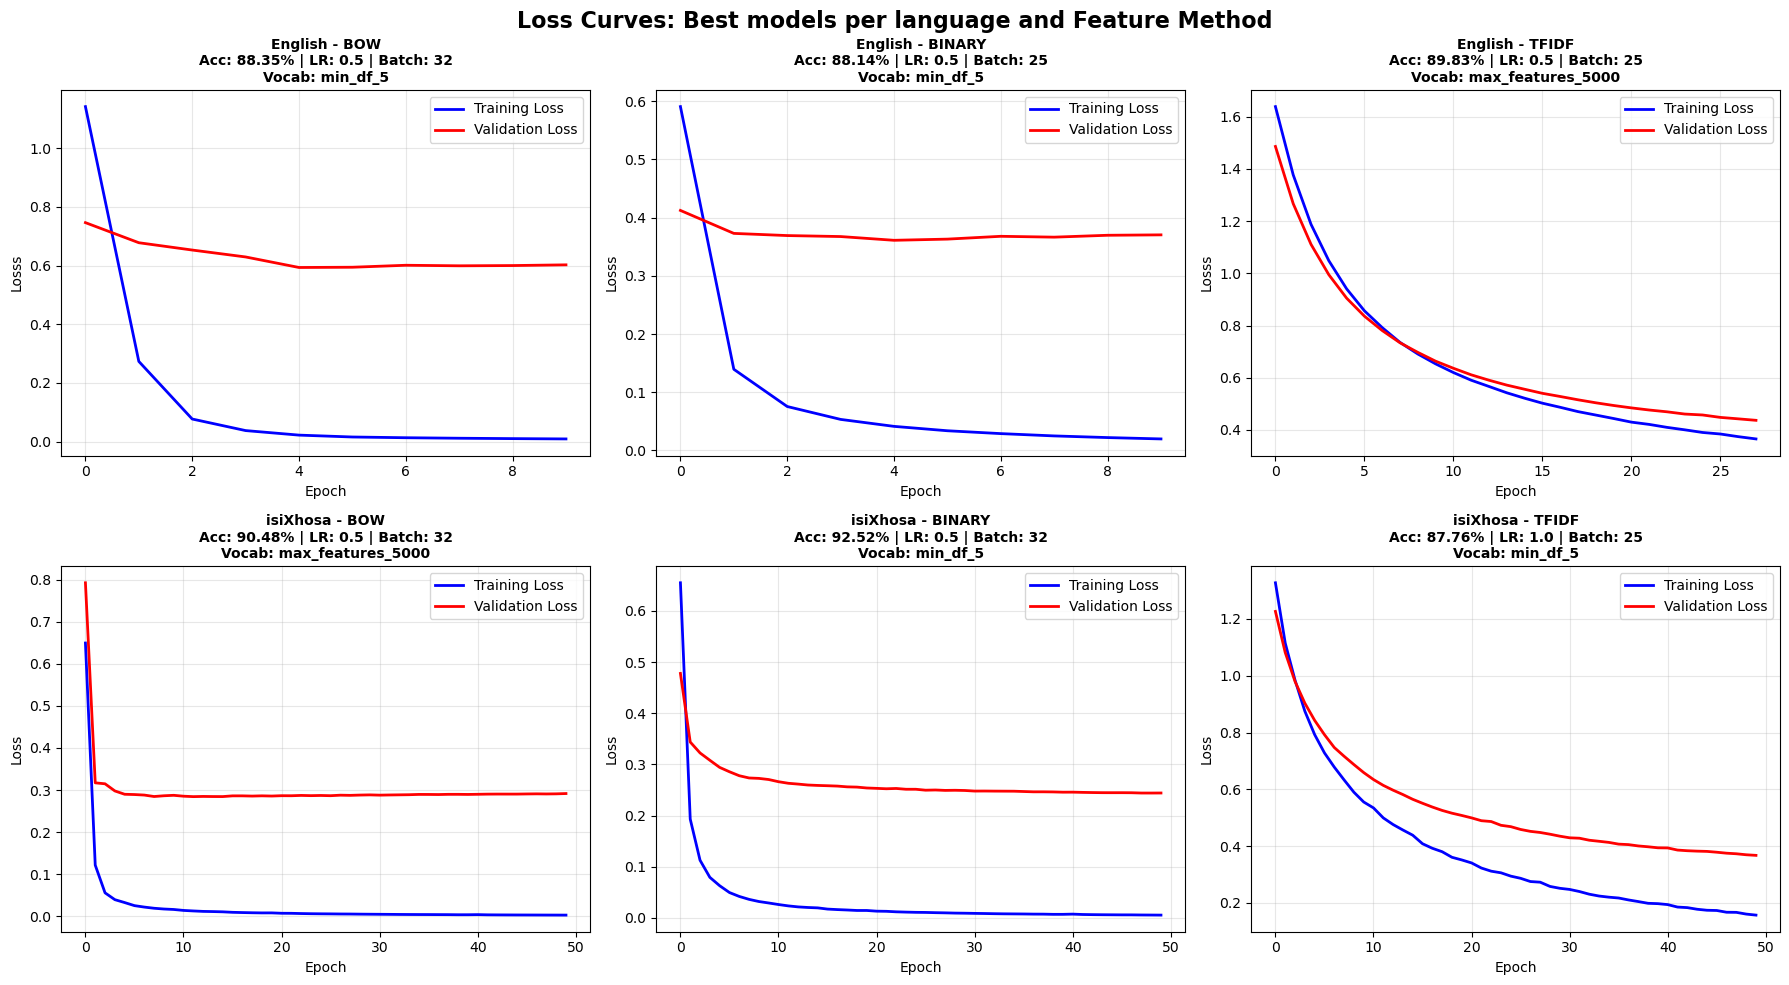

In [67]:
# Running experiments for ENGLISH 
print(">>> Eglish Hyperparameter Tuning experiments <<<")
tuner_eng = Tuner(train_eng, dev_eng, y_train_eng, y_dev_eng, labels_eng, 'eng')
results_eng = tuner_eng.run_experiments() 
best_models_eng = tuner_eng.find_best_models()
tuner_eng.print_best_models()

# running experiments for IsiXhosa  
print("\n>>>> IsiXhosa Hyperparameter Tuning experiments <<<")
tuner_xho = Tuner(train_xho, dev_xho, y_train_xho, y_dev_xho, labels_xho, 'xho')
results_xho = tuner_xho.run_experiments()
best_models_xho = tuner_xho.find_best_models()
tuner_xho.print_best_models()

# graphing the loss plots for the best models per language and featture extraction method
print("\n>>> GENERATING The BEST LOSS CURVES <<<")
best_models(best_models_eng, best_models_xho)

**Test set evaulation**  

In [68]:
def final_tester(best_model, train_texts, test_texts, y_train, y_test, labels, language,yes=False):
    """Test the best model per language"""
    
    print(f"\n Testing the best {language.upper()} Model on test set")
    print("-"*50)
    
    #recreating the feature extractor with best settings
    extractor = FeatureExtraction(method=best_model['feature_method'],max_features=best_model['max_features'],min_df=best_model['min_df'],max_df=0.95,language=language,remove_stopwords=False)
    
    X_train = extractor.fit(train_texts).transform(train_texts)#fitting 
    X_test = extractor.transform(test_texts)
    
    print(f"Training on {len(train_texts)} samples, testing on {len(test_texts)} samples")
    print(f"Feature dimension: {X_train.shape[1]}")

    generator = torch.Generator().manual_seed(42)
    
    train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=best_model['batch_size'], shuffle=True,generator=generator)
    test_loader = DataLoader(TensorDataset(X_test, y_test),batch_size=best_model['batch_size'], shuffle=False,generator=generator)

    set_seed(42)
    # final model with best learning rate
    input_size = X_train.shape[1]
    model = MultinomialLogisticRegression(input_size, len(labels))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=best_model['learning_rate'])
    
    trainer = NewsClassifierTrainer(model, criterion, optimizer)
    
    #final training ,made verbose to see the final training process
    print(f"\n FINAL TRAINING ON TRAINING DATA:")
    if language =='eng':
        trainer.train(train_loader, test_loader, early_stopping=True, patience=5, printer=True)
    else:
        trainer.train(train_loader, test_loader, num_epochs=50, early_stopping=False, printer=True)
        
    print(f"Validation Accuracy (from tuning): {best_model['val_accuracy']:.2f}%")
    print(f"\nFinal Test Set Evaluation:")
    test_accuracy, predictions, targets = trainer.evaluate(test_loader)


    if yes:
        metrics_outcomes(test_accuracy, predictions, targets, labels, best_model,language)
    return {'test_accuracy': test_accuracy,'predictions': predictions, 'targets': targets,'trainer': trainer,'extractor': extractor}

def metrics_outcomes(test_accuracy, predictions, targets, labels, best_model,language):#printing all required metrics for task 7
    
    y_true = np.array(targets)
    y_pred = np.array(predictions)
    
    print(f"\n" + "="*35)
    print("MODEL METRICS!!")
    print("="*35)
    
    print(f"Model: {best_model['feature_method'].upper()} | LR: {best_model['learning_rate']} | Batch: {best_model['batch_size']}")
    print(f"Vocabulary: {best_model.get('vocab_setting', 'N/A')}")
    
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)#getting microo and macro averaged values
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\nMicro-Averaged:")
    print(f"   Precision: {precision_micro:.4f}")
    print(f"   Recall:    {recall_micro:.4f}")
    print(f"   F1-Score:  {f1_micro:.4f}")
    
    print(f"\nMacro-Averaged :")
    print(f"   Precision: {precision_macro:.4f}")
    print(f"   Recall:    {recall_macro:.4f}")
    print(f"   F1-Score:  {f1_macro:.4f}")
    
    print(f"\nPer-class Metrics:")#per class
    class_report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
    print(class_report)
    
    print(f"\nCONFUSION MATRIX:")
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels,language)

def plot_confusion_matrix(cm, labels,language):
    """visually plotting the confusion matrix"""
    
    plt.figure(figsize=(8, 6))
    if language=='xho':
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)#creating a heapmap
        plt.title('Confusion Matrix for isiXhosa')
    else:
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)#creating a heapmap
        plt.title('Confusion Matrix for English')
    plt.colorbar()
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual value')
    plt.xlabel('Predicted')
    plt.show()

In [69]:
# Testing the overall best English model 
best_eng_model = { 'feature_method': 'tfidf','learning_rate': 0.5,  'batch_size': 25,'max_features': 5000,'min_df': 1,'vocab_setting': 'max_features_5000','val_accuracy': 89.83}
eng_test_results = final_tester(best_eng_model,train_eng, test_eng,y_train_eng, y_test_eng, labels_eng, 'eng')


 Testing the best ENG Model on test set
--------------------------------------------------
Training on 3309 samples, testing on 948 samples
Feature dimension: 5000

 FINAL TRAINING ON TRAINING DATA:
Model is training...
Stopping criteria: Early Stopping
Epoch  Train Loss   Train Acc  Val Loss     Val Acc   
------------------------------------------------------------
1      1.6457       43.34      1.5091       73.52     
2      1.3934       72.23      1.3012       79.64     
3      1.2087       82.47      1.1486       80.80     
4      1.0706       84.56      1.0322       85.34     
5      0.9626       86.70      0.9426       85.55     
6      0.8778       87.31      0.8722       86.81     
7      0.8131       87.82      0.8147       87.45     
8      0.7557       87.97      0.7677       87.66     
9      0.7106       88.85      0.7282       86.92     
10     0.6724       89.21      0.6930       87.76     
11     0.6383       89.39      0.6629       87.87     
12     0.6087       89.6


 Testing the best XHO Model on test set
--------------------------------------------------
Training on 1032 samples, testing on 297 samples
Feature dimension: 6073

 FINAL TRAINING ON TRAINING DATA:
Model is training...
Stopping criteria: Fixed 50 Epochs
Epoch  Train Loss   Train Acc  Val Loss     Val Acc   
------------------------------------------------------------
1      0.6606       80.04      0.5119       81.82     
2      0.1904       97.38      0.3426       89.56     
3      0.1102       99.03      0.3280       89.90     
4      0.0775       99.52      0.3208       89.56     
5      0.0611       100.00     0.3135       89.23     
6      0.0482       100.00     0.3045       89.90     
7      0.0408       100.00     0.3031       89.56     
8      0.0353       100.00     0.2973       89.90     
9      0.0311       100.00     0.2987       89.90     
10     0.0281       100.00     0.3001       89.56     
11     0.0254       100.00     0.2943       89.56     
12     0.0228       100

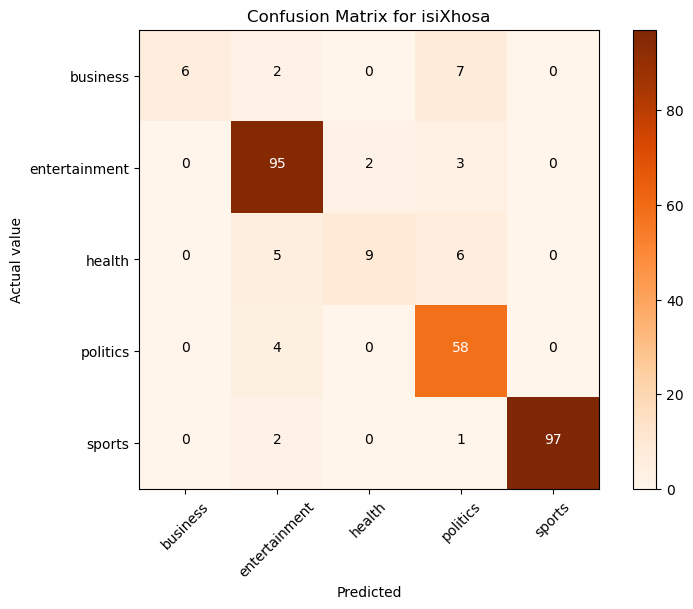

In [70]:
# Testing the overall isiXhosa model
best_xho_model = { 'feature_method': 'binary','learning_rate': 0.5,'batch_size': 32,'max_features': None,'min_df': 5,'vocab_setting': 'min_df_5', 'val_accuracy': 92.52}#the best isiXhosa model
xho_test_results = final_tester(best_xho_model, train_xho, test_xho, y_train_xho, y_test_xho, labels_xho, 'xho',yes=True)

# 6. isiXhosa training decisions

In [71]:
class Regularizer:
    """L1 and L2 regularization experiments with variable coefficients"""
    
    def __init__(self, train_texts, val_texts, y_train, y_val, labels, base_model):
        self.generator = torch.Generator().manual_seed(42)
        self.train_texts = train_texts
        self.val_texts = val_texts
        self.y_train = y_train
        self.y_val = y_val
        self.labels = labels
        self.base_model = base_model
    
    def run_regularization_experiments(self):
        """Experiment with L1 and L2 regularization"""
        print("\nREGULARIZATION EXPERIMENTS")
        print("-"*40)
        
        baseline_acc = self.base_model['val_accuracy']
        print(f"Baseline with no regularization): {baseline_acc:.2f}%")
        best_acc = baseline_acc
        best_config = {'reg_type': None, 'alpha': 0}
        

        l1_alphas = [0.000001 , 0.1, 0.5, 1.0]# L1  coefficients
        for l1_alpha in l1_alphas:
            print(f"\nL1 regularization (α = {l1_alpha})...")
            acc = self._train_single_experiment('l1', l1_alpha)
            print(f"  Result: {acc:.2f}%")
            
            if acc > best_acc:
                best_acc = acc
                best_config = {'reg_type': 'l1', 'alpha': l1_alpha}
        
        
        l2_alphas = [0.000001 , 0.1, 0.5, 1.0]# L2 coefficients
        for l2_alpha in l2_alphas:
            print(f"\nL2 regularization (α = {l2_alpha})...")
            acc = self._train_single_experiment('l2', l2_alpha)
            print(f"  Result: {acc:.2f}%")
            
            if acc > best_acc:
                best_acc = acc
                best_config = {'reg_type': 'l2', 'alpha': l2_alpha}
        
        return best_config
    
    def _train_single_experiment(self, reg_type, alpha):
        """a single regularization experiment"""
        
        extractor = FeatureExtraction(method=self.base_model['feature_method'], max_features=self.base_model['max_features'], min_df=self.base_model['min_df'], max_df=0.95,language='xho',remove_stopwords=True)
        
        X_train = extractor.fit(self.train_texts).transform(self.train_texts)
        X_val = extractor.transform(self.val_texts)
        
        train_loader = DataLoader(TensorDataset(X_train, self.y_train), batch_size=self.base_model['batch_size'], shuffle=True,generator=self.generator)
        val_loader = DataLoader(TensorDataset(X_val, self.y_val), batch_size=self.base_model['batch_size'], shuffle=False,generator=self.generator)
        set_seed(42)
        input_size = X_train.shape[1]
        model = MultinomialLogisticRegression(input_size, len(self.labels))
        base_criterion = nn.CrossEntropyLoss()
        
        # customize l1 rehularization
        if reg_type == 'l1':
            def l1_regularized_criterion(output, target):
                base_loss = base_criterion(output, target)
                
                l1_penalty = 0.0 # aplying only to weight parameters and not biases
                for name, param in model.named_parameters():
                    if 'weight' in name:  
                        l1_penalty += torch.norm(param, 1)  # L1 norm
                return base_loss + alpha * l1_penalty
            
            criterion = l1_regularized_criterion
            optimizer = torch.optim.SGD(model.parameters(), lr=self.base_model['learning_rate'])
            
        elif reg_type == 'l2':#l2 regularization
            criterion = base_criterion
            optimizer = torch.optim.SGD(model.parameters(), lr=self.base_model['learning_rate'], 
                                      weight_decay=alpha)
        else:
            criterion = base_criterion #no regularization
            optimizer = torch.optim.SGD(model.parameters(), lr=self.base_model['learning_rate'])
        
        trainer = NewsClassifierTrainer(model, criterion, optimizer)
        val_accuracy = trainer.train(train_loader, val_loader, num_epochs=50,early_stopping=False, printer=False)
        return val_accuracy

In [72]:
regularizer = Regularizer(train_xho, dev_xho, y_train_xho, y_dev_xho, labels_xho, best_xho_model)
best_reg_config = regularizer.run_regularization_experiments()

print(f"\nBest regularization: {best_reg_config}")


REGULARIZATION EXPERIMENTS
----------------------------------------
Baseline with no regularization): 92.52%

L1 regularization (α = 1e-06)...
  Result: 92.52%

L1 regularization (α = 0.1)...
  Result: 42.86%

L1 regularization (α = 0.5)...
  Result: 40.14%

L1 regularization (α = 1.0)...
  Result: 38.78%

L2 regularization (α = 1e-06)...
  Result: 92.52%

L2 regularization (α = 0.1)...
  Result: 85.03%

L2 regularization (α = 0.5)...
  Result: 55.10%

L2 regularization (α = 1.0)...
  Result: 65.31%

Best regularization: {'reg_type': None, 'alpha': 0}


In [73]:
class Balancer:
    """handling class imbalance with variable sampling rates"""
    generator = torch.Generator().manual_seed(42)
    def __init__(self, train_texts, val_texts, y_train, y_val, labels, base_model):
        self.generator = torch.Generator().manual_seed(42)
        self.train_texts = train_texts
        self.val_texts = val_texts
        self.y_train = y_train
        self.y_val = y_val
        self.labels = labels
        self.base_model = base_model
        self.results = []
    
    def run_sampling_experiments(self):
        """running sampling experiments with different sampling rates"""
        print("\nCLASS IMBALANCE EXPERIMATS")
        print("-"*40)
        
        class_counts = torch.bincount(self.y_train)
        print(f"Classes: {self.labels}")
        print(f"Original class distribution: {class_counts.tolist()}")
        
        
        baseline_result = {'experiment_type': 'class_imbalance','method': 'baseline','sampling_rate': 'N/A','val_accuracy': self.base_model['val_accuracy'],'trainer': None,'baseline_accuracy': self.base_model['val_accuracy']}
        self.results.append(baseline_result)
        print(f"\nOriginal with no sampling: {self.base_model['val_accuracy']:.2f}%")
        
        sampling_rates = [0.25, 0.5, 1.0, 2.0, 4.0]  #sampling rates to test
        
        for rate in sampling_rates:
            print(f"\nSAMPLING RATE: {rate}x")
            print("-" *20)
            
            print(f"Upsampling...")#upsampling per rate
            upsampled_loader = self._create_sampled_loader('upsample', rate)
            upsampled_result = self._train_with_sampling(upsampled_loader, 'upsample', rate)
            self.results.append(upsampled_result)
            
            print(f"Downsampling...")#Downsampling per rate
            downsampled_loader = self._create_sampled_loader('downsample', rate)
            downsampled_result = self._train_with_sampling(downsampled_loader, 'downsample', rate)
            self.results.append(downsampled_result)
        
        return self.results
    
    def _create_sampled_loader(self, method, sampling_rate):
        """Create data loader with variable sampling rate"""
        from torch.utils.data import WeightedRandomSampler
        
        class_counts = torch.bincount(self.y_train)
        
        if method == 'upsample':
            base_weights = 1.0 / class_counts.float()
            class_weights = base_weights * sampling_rate
            
        else:  # 'downsample'  
            class_proportions = class_counts.float() / class_counts.float().sum()
            class_weights = (1.0 / class_proportions) * (1.0 / sampling_rate)
        
        sample_weights = class_weights[self.y_train]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(self.y_train), replacement=True,generator=self.generator)
        
        extractor = FeatureExtraction(method=self.base_model['feature_method'],max_features=self.base_model['max_features'],min_df=self.base_model['min_df'],max_df=0.95,language='xho',remove_stopwords=True)
        
        X_train = extractor.fit(self.train_texts).transform(self.train_texts)
        dataset = TensorDataset(X_train, self.y_train)
        balanced_loader = DataLoader(dataset, batch_size=self.base_model['batch_size'], sampler=sampler,generator=self.generator)
        
        return balanced_loader
    
    def _train_with_sampling(self, train_loader, method, sampling_rate):
        """Train model with different sampling """
        set_seed(42)
        extractor = FeatureExtraction(method=self.base_model['feature_method'],max_features=self.base_model['max_features'],min_df=self.base_model['min_df'],max_df=0.95,language='xho',remove_stopwords=True)
        
        X_val = extractor.fit(self.train_texts).transform(self.val_texts)
        val_loader = DataLoader(TensorDataset(X_val, self.y_val), batch_size=self.base_model['batch_size'], shuffle=False,generator=self.generator)
        
        input_size = X_val.shape[1]
        model = MultinomialLogisticRegression(input_size, len(self.labels))
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=self.base_model['learning_rate'])
        
        trainer = NewsClassifierTrainer(model, criterion, optimizer)
        
        val_accuracy = trainer.train(train_loader, val_loader, num_epochs=50, early_stopping=False, printer=False)
        
        result = {'experiment_type': 'class_imbalance','method': method,'sampling_rate': sampling_rate,'val_accuracy': val_accuracy,'trainer': trainer,'baseline_accuracy': self.base_model['val_accuracy']}
        print(f"  Result: {val_accuracy:.2f}%")
        return result
    
    def analyze_results(self):
        """Find and print the best sampling strategy"""
        print("\n" + "="*20)
        print("OUTCOME!")
        print("="*20)
        
        baseline = [r for r in self.results if r['method'] == 'baseline'][0]
        
        sampling_results = [r for r in self.results if r['method'] != 'baseline']#BEST OVERALL STRATEGY
        if sampling_results:
            best_result = max(sampling_results, key=lambda x: x['val_accuracy'])
            
            self.final_results(best_result, baseline)
            
            return best_result
        return baseline
    
    def final_results(self, best_result, baseline):
        """printing the best """
        improvement = best_result['val_accuracy'] - baseline['val_accuracy']
        
        print(f"BEST SAMPLING STRATEGY:")
        print(f"   Method: {best_result['method']}")
        print(f"   sSampling Rate: {best_result['sampling_rate']}x")
        print(f"   Validation Accuracy: {best_result['val_accuracy']:.2f}%")
        print(f"   Improvement: {improvement:+.2f}%")

In [74]:
#run experiments
balancer = Balancer(train_xho, dev_xho, y_train_xho, y_dev_xho, labels_xho, best_xho_model)
sampling_results = balancer.run_sampling_experiments()
best_sampling = balancer.analyze_results()


CLASS IMBALANCE EXPERIMATS
----------------------------------------
Classes: ['business', 'entertainment', 'health', 'politics', 'sports']
Original class distribution: [50, 350, 70, 215, 347]

Original with no sampling: 92.52%

SAMPLING RATE: 0.25x
--------------------
Upsampling...
  Result: 93.20%
Downsampling...
  Result: 92.52%

SAMPLING RATE: 0.5x
--------------------
Upsampling...
  Result: 93.88%
Downsampling...
  Result: 93.20%

SAMPLING RATE: 1.0x
--------------------
Upsampling...
  Result: 93.88%
Downsampling...
  Result: 92.52%

SAMPLING RATE: 2.0x
--------------------
Upsampling...
  Result: 92.52%
Downsampling...
  Result: 92.52%

SAMPLING RATE: 4.0x
--------------------
Upsampling...
  Result: 93.20%
Downsampling...
  Result: 93.88%

OUTCOME!
BEST SAMPLING STRATEGY:
   Method: upsample
   sSampling Rate: 0.5x
   Validation Accuracy: 93.88%
   Improvement: +1.36%


# 7. Evaluation


 Testing the best ENG Model on test set
--------------------------------------------------
Training on 3309 samples, testing on 948 samples
Feature dimension: 5000

 FINAL TRAINING ON TRAINING DATA:
Model is training...
Stopping criteria: Early Stopping
Epoch  Train Loss   Train Acc  Val Loss     Val Acc   
------------------------------------------------------------
1      1.6457       43.34      1.5091       73.52     
2      1.3934       72.23      1.3012       79.64     
3      1.2087       82.47      1.1486       80.80     
4      1.0706       84.56      1.0322       85.34     
5      0.9626       86.70      0.9426       85.55     
6      0.8778       87.31      0.8722       86.81     
7      0.8131       87.82      0.8147       87.45     
8      0.7557       87.97      0.7677       87.66     
9      0.7106       88.85      0.7282       86.92     
10     0.6724       89.21      0.6930       87.76     
11     0.6383       89.39      0.6629       87.87     
12     0.6087       89.6

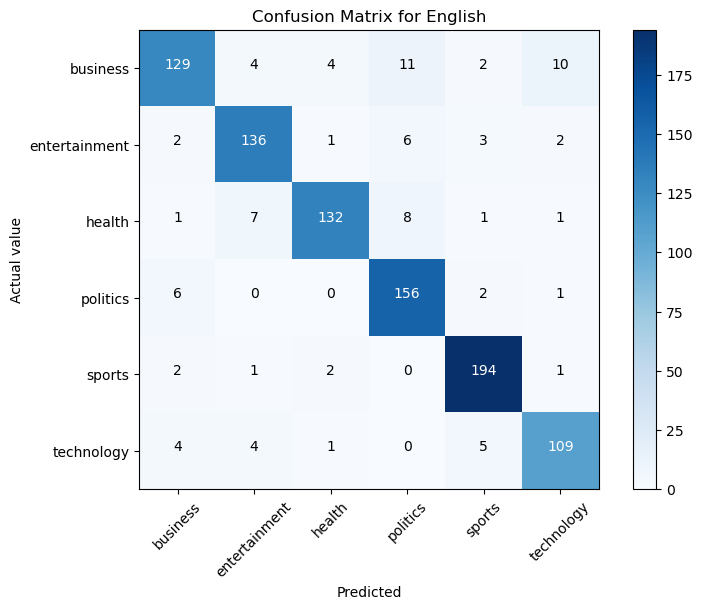

In [75]:
# Testing the overall best English model 
best_eng_model = { 'feature_method': 'tfidf','learning_rate': 0.5,  'batch_size': 25,'max_features': 5000,'min_df': 1,'vocab_setting': 'max_features_5000','val_accuracy': 89.83}
eng_test_results = final_tester(best_eng_model,train_eng, test_eng,y_train_eng, y_test_eng, labels_eng, 'eng',yes=True)


 FINAL TRAINING ON isiXhosa WITH UPSAMPLING:
Model is training...
Stopping criteria: Fixed 50 Epochs
Epoch  Train Loss   Train Acc  Val Loss     Val Acc   
------------------------------------------------------------
1      0.6047       84.59      0.4679       89.80     
2      0.2181       97.97      0.3664       90.48     
3      0.1118       99.81      0.3226       93.20     
4      0.0740       100.00     0.2997       94.56     
5      0.0684       99.52      0.2818       93.20     
6      0.0521       99.71      0.2716       93.88     
7      0.0499       99.81      0.2691       93.88     
8      0.0373       99.90      0.2637       93.20     
9      0.0334       100.00     0.2606       93.20     
10     0.0308       99.90      0.2561       93.20     
11     0.0287       99.90      0.2517       93.20     
12     0.0228       100.00     0.2493       93.20     
13     0.0211       100.00     0.2469       93.88     
14     0.0215       99.90      0.2434       94.56     
15     0.019

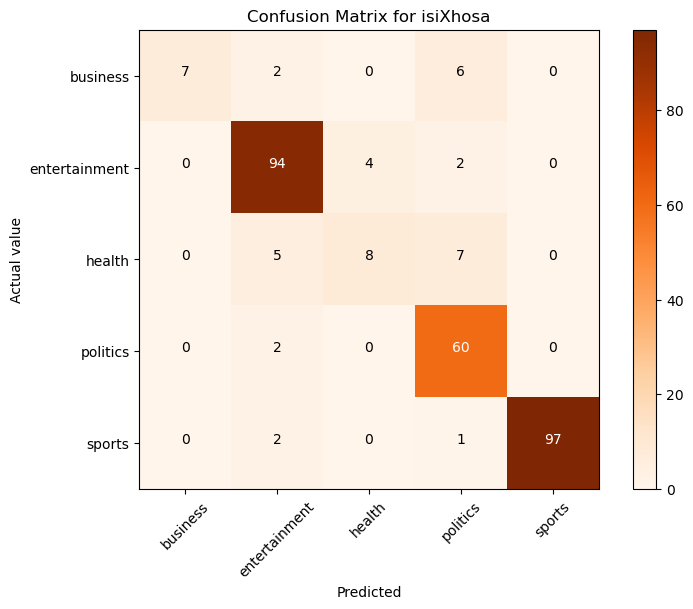

In [76]:
    """final tester for isiXhosa with upsampling as it improved the performance by a small margin for the best isiXhosa mdoel""" 
    generator = torch.Generator().manual_seed(42)
    
    #manually upsampling 
    extractor = FeatureExtraction(method=best_xho_model['feature_method'],max_features=best_xho_model['max_features'],
        min_df=best_xho_model['min_df'],max_df=0.95,language='xho',remove_stopwords=True)
    
    X_train = extractor.fit(train_xho).transform(train_xho)
    X_dev = extractor.transform(dev_xho)  # Use dev set for validation during training
    X_test = extractor.transform(test_xho)
    
    class_counts = torch.bincount(y_train_xho)
    base_weights = 1.0 / class_counts.float()
    class_weights = base_weights * 0.5  # 0.5x upsampling rate
    sample_weights = class_weights[y_train_xho]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train_xho), replacement=True,generator=generator)
    
    train_loader = DataLoader(TensorDataset(X_train, y_train_xho),batch_size=best_xho_model['batch_size'], sampler=sampler,generator=generator)
    
    val_loader = DataLoader(TensorDataset(X_dev, y_dev_xho),batch_size=best_xho_model['batch_size'], shuffle=False,generator=generator)
    
    test_loader = DataLoader(TensorDataset(X_test, y_test_xho),batch_size=best_xho_model['batch_size'], shuffle=False,generator=generator)

    set_seed(42)
    #training  and evaluating 
    input_size = X_train.shape[1]
    model = MultinomialLogisticRegression(input_size, len(labels_xho))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=best_xho_model['learning_rate'])
    
    trainer = NewsClassifierTrainer(model, criterion, optimizer)
    
    print(f"\n FINAL TRAINING ON isiXhosa WITH UPSAMPLING:")
    trainer.train(train_loader, val_loader, num_epochs=50, early_stopping=False, printer=True)
    test_accuracy, predictions, targets = trainer.evaluate(test_loader)
    metrics_outcomes(test_accuracy, predictions, targets, labels_xho, best_xho_model,language='xho')

# 8. Weight analysis

In [77]:
"""I cannot take ful credit of the code that follows I recieved help from deepseek ai as I lacked the knowhow of how to accociate the weights with the words in my vocabulary"""
print("\n" + "="*45)
print("Weight Anlysis and Extraction for isiXhosa")
print("="*45)

weights, biases = xho_test_results['trainer'].model.get_weights()#getting leanrned weights
feature_names = xho_test_results['extractor'].vectorizer.get_feature_names_out()

print(f"Model weights shape: {weights.shape}")
print(f"Number of classes: {len(labels_xho)}")
print(f"Vocabulary size: {len(feature_names)}")


for class_idx, class_label in enumerate(labels_xho):#per class analysis
    print(f"\nClass: {class_label.upper()}")
    print("-" * 50)
    class_weights = weights[class_idx]#weights for this class 
    
    top_positive_indices = torch.topk(class_weights, 10).indices#words that strongly indicate this class
    top_positive_words = [feature_names[i] for i in top_positive_indices]
    top_positive_weights = [class_weights[i].item() for i in top_positive_indices]
    
    print(f"Top 10 words that strongly indicate '{class_label}':")
    for word, weight in zip(top_positive_words, top_positive_weights):
        print(f"  {word}: {weight:.4f}")
    
    top_negative_indices = torch.topk(-class_weights, 10).indices #words that strongly indicate NOT this class
    top_negative_words = [feature_names[i] for i in top_negative_indices]
    top_negative_weights = [class_weights[i].item() for i in top_negative_indices]
    
    print(f"\nTop 10 words that strongly indicate any other class:")
    for word, weight in zip(top_negative_words, top_negative_weights):
        print(f"  {word}: {weight:.4f}")


Weight Anlysis and Extraction for isiXhosa
Model weights shape: torch.Size([5, 6073])
Number of classes: 5
Vocabulary size: 6073

Class: BUSINESS
--------------------------------------------------
Top 10 words that strongly indicate 'business':
  ishishini: 0.6378
  oosomashishini: 0.5321
  amashishini: 0.4866
  amafama: 0.4704
  asakhasayo: 0.3840
  shishini: 0.3696
  lezolimo: 0.3616
  ushishino: 0.3530
  kudizwe: 0.3398
  sebe: 0.3340

Top 10 words that strongly indicate any other class:
  lo: -0.3791
  ngalo: -0.3184
  ukuba: -0.3116
  afrika: -0.2791
  akukho: -0.2549
  uza: -0.2278
  ka: -0.2231
  emva: -0.2201
  solezwe: -0.2164
  bafuna: -0.2153

Class: ENTERTAINMENT
--------------------------------------------------
Top 10 words that strongly indicate 'entertainment':
  kamabonakude: 0.8010
  fm: 0.6506
  mdlalo: 0.6387
  uza: 0.6269
  nanjengoko: 0.5868
  lesixhosa: 0.5711
  kunye: 0.5113
  kumdlalo: 0.5059
  solezwe: 0.4874
  uzalo: 0.4526

Top 10 words that strongly indica